## Building A Basic Transformer

In [78]:
import torch
import numpy as np
from torch import nn

In [79]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_v, d_model, num_heads, p=0.):
        super(MultiHeadAttention, self).__init__()
        self.d_modeol = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.num_heads = num_heads
        self.dropout = nn.Dropout(p=p)

        self.W_Q = nn.Linear(d_model, d_k * num_heads)
        self.W_K = nn.Linear(d_model, d_k * num_heads)
        self.W_V = nn.Linear(d_model, d_v * num_heads)
        self.W_out = nn.Linear(d_v * num_heads, d_model)

        nn.init.normal_(self.W_Q.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.W_K.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.W_V.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))
        nn.init.normal_(self.W_out.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))
    
    def forward(self, Q, K, V, attn_mask, **kwargs):
        N = Q.size(0)
        q_len, k_len = Q.size(1), K.size(1)
        d_k, d_v = self.d_k, self.d_v
        num_heads = self.num_heads

        Q = self.W_Q(Q).view(N, -1, num_heads, d_k).transpose(1, 2)
        K = self.W_K(K).view(N, -1, num_heads, d_k).transpose(1, 2)
        V = self.W_V(V).view(N, -1, num_heads, d_v).transpose(1, 2)

        if attn_mask is not None:
            assert attn_mask.size() == (N, q_len, k_len)
            attn_mask = attn_mask.unsqueeze(1).repeat(1, num_heads, 1, 1)
            attn_mask = attn_mask.bool()

        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        if attn_mask is not None:
            scores.masked_fill_(attn_mask, -1e4)
        attns = torch.softmax(scores, dim=-1)
        attns = self.dropout(attns)
        
        output = torch.matmul(attns, V)

        output = output.transpose(1,2).contiguous().reshape(N, -1, d_v * num_heads)
        output = self.W_out(output)

        return output


In [80]:
def pos_sinusoid_embedding(seq_len, d_model):
    embeddings = torch.zeros((seq_len, d_model))
    for i in range(d_model):
        f = torch.sin if i % 2 == 0 else torch.cos
        embeddings[:, i] = f(torch.arange(0, seq_len) / np.power(1e4, 2 * (i // 2) / d_model))
    return embeddings.float()

In [81]:
class PoswiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, p=0.):
        super(PoswiseFFN, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.conv1 = nn.Conv1d(d_model, d_ff, 1, 1, 0)
        self.conv2 = nn.Conv1d(d_ff, d_model, 1, 1, 0)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=p)

    def forward(self, X):
        out = self.conv1(X.transpose(1,2))
        out = self.relu(out)
        out = self.conv2(out).transpose(1,2)
        out = self.dropout(out)
        return out

In [82]:
def get_len_mask(b: int, max_len: int, feat_lens: torch.Tensor, device: torch.device) -> torch.Tensor:
    attn_maks = torch.ones((b, max_len, max_len), device=device)
    for i in range(b):
        attn_maks[i, :, :feat_lens[i]] = 0
    return attn_maks.to(torch.bool)

def get_subsequent_mask(b: int, max_len: int, device: torch.device) -> torch.Tensor:
    return torch.triu(torch.ones((b, max_len, max_len), device=device), diagonal=1).to(torch.bool)

def get_enc_dec_mask(
        b: int, max_feat_len: int, feat_lens: torch.Tensor, max_label_len: int, device: torch.device
) -> torch.Tensor:
    attn_mask = torch.zeros((b, max_label_len, max_feat_len), device=device)
    for i in range(b):
        attn_mask[i, :, feat_lens[i]:] = 1
    return attn_mask.to(torch.bool)

In [83]:
class EncoderLayer(nn.Module):
    def __init__(self, dim, n, dff, dropout_posfnn, dropout_attn):
        """
        Args:
            dim: input dimension
            n: number of heads
            dff: hidden layer dimension
            dropout_posfnn: dropout rate for position-wise feed-forward network
            dropout_attn: dropout rate for multi-head attention
        """
        super(EncoderLayer, self).__init__()
        assert dim % n == 0
        hdim = dim // n

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.multi_head_attn = MultiHeadAttention(hdim, hdim, dim, n, dropout_attn)
        self.poswise_ffn = PoswiseFFN(dim, dff, p=dropout_posfnn)
    
    def forward(self, enc_in, attn_mask):
        residual = enc_in
        context = self.multi_head_attn(enc_in, enc_in, enc_in, attn_mask)
        out = self.norm1(residual + context)
        residual = out

        context = self.poswise_ffn(out)
        out = self.norm2(residual + context)

        return out

In [84]:
class Encoder(nn.Module):
    def __init__(self, dropout_emb, dropout_posffn, dropout_attn,
                 num_layers, enc_dim, num_heads, dff, tgt_len,):
        """ 
        Args:
            dropout_emb: dropout rate for embedding layer
            dropout_posfnn: dropout rate for position-wise feed-forward network
            dropout_attn: dropout rate for multi-head attention
            num_layers: number of encoder layers
            enc_dim: encoder layer dimension
            num_heads: number of heads
            dff: hidden layer dimension
            tgt_len: target sequence length
        """
        super(Encoder, self).__init__()
        self.tgt_len = tgt_len
        self.pos_emb = nn.Embedding.from_pretrained(pos_sinusoid_embedding(tgt_len, enc_dim), freeze=True)
        self.emb_dropout = nn.Dropout(p=dropout_emb)
        self.layers = nn.ModuleList(
            [EncoderLayer(enc_dim, num_heads, dff, dropout_posffn, dropout_attn) for _ in range(num_layers)]
        )
    
    def forward(self, X, X_lens, mask=None):
        batch_size, seq_len, d_model = X.shape
        out = X + self.pos_emb(torch.arange(seq_len, device=X.device))
        out = self.emb_dropout(out)
        for layer in self.layers:
            out = layer(out, mask)
        return out

In [85]:
class DecoderLayer(nn.Module):
    def __init__(self, dim, n, dff, dropout_posffn, dropout_attn):
        super(DecoderLayer, self).__init__()
        assert dim % n == 0
        hdim = dim // n

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)

        self.poswise_ffn = PoswiseFFN(dim, dff, p=dropout_posffn)
        self.dec_attn = MultiHeadAttention(hdim, hdim, dim, n, p=dropout_attn)
        self.enc_dec_attn = MultiHeadAttention(hdim, hdim, dim, n, p=dropout_attn)

    def forward(self, dec_in, enc_out, dec_mask, dec_enc_mask, cache=None, freqs_cis=None):
        residual = dec_in
        context = self.dec_attn(dec_in, dec_in, dec_in, dec_mask)
        dec_out = self.norm1(residual + context)

        residual = dec_out
        context = self.enc_dec_attn(dec_out, enc_out, enc_out, dec_enc_mask)
        dec_out = self.norm2(residual + context)

        residual = dec_out
        out = self.poswise_ffn(dec_out)
        dec_out = self.norm3(residual + out)

        return dec_out

In [86]:
class Decoder(nn.Module):
    def __init__(
            self, dropout_emb, dropout_posffn, dropout_attn,
            num_layers, dec_dim, num_heads, dff, tgt_len, tgt_vocab_size,
    ):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, dec_dim)
        self.dropout_emb = nn.Dropout(p=dropout_emb)

        self.pos_emb = nn.Embedding.from_pretrained(pos_sinusoid_embedding(tgt_len, dec_dim), freeze=True)
        self.layers = nn.ModuleList(
            [DecoderLayer(dec_dim, num_heads, dff, dropout_posffn, dropout_attn) for _ in range(num_layers)]
        )

    def forward(self, lables, enc_out, dec_mask, dec_enc_mask, cache=None):
        tgt_emb = self.tgt_emb(lables)
        pos_emb = self.pos_emb(torch.arange(lables.size(1), device=lables.device))
        dec_out = self.dropout_emb(tgt_emb + pos_emb)

        for layer in self.layers:
            dec_out = layer(dec_out, enc_out, dec_mask, dec_enc_mask, cache)
        return dec_out

In [87]:
class Transformer(nn.Module):
    def __init__(
            self, frontend: nn.Module, encoder: nn.Module, decoder: nn.Module,
            dec_out_dim: int, vocab: int
    ) -> None:
        super(Transformer, self).__init__()
        self.frontend = frontend
        self.encoder = encoder
        self.decoder = decoder
        self.fc = nn.Linear(dec_out_dim, vocab)
    
    def forward(self, X: torch.Tensor, X_lens: torch.Tensor, labels: torch.Tensor):
        X_lens, labels = X_lens.long(), labels.long()
        b = X.size(0)
        device = X.device

        out = self.frontend(X)
        max_feat_len = out.size(1)
        max_label_len = labels.size(1)

        enc_mask = get_len_mask(b, max_feat_len, X_lens, device)
        enc_out = self.encoder(out, X_lens, enc_mask)

        dec_mask = get_subsequent_mask(b, max_label_len, device)
        dec_enc_mask = get_enc_dec_mask(b, max_feat_len, X_lens, max_label_len, device)
        dec_out = self.decoder(labels, enc_out, dec_mask, dec_enc_mask)
        logits = self.fc(dec_out)

        return logits

In [88]:
if __name__ == "__main__":
    # constants
    batch_size = 16                 # batch size
    max_feat_len = 100              # the maximum length of input sequence
    max_label_len = 50              # the maximum length of output sequence
    fbank_dim = 80                  # the dimension of input feature
    hidden_dim = 512                # the dimension of hidden layer
    vocab_size = 26                 # the size of vocabulary

    # dummy data
    fbank_feature = torch.randn(batch_size, max_feat_len, fbank_dim)        # input sequence
    feat_lens = torch.randint(1, max_feat_len, (batch_size,))               # the length of each input sequence in the batch
    labels = torch.randint(0, vocab_size, (batch_size, max_label_len))      # output sequence
    label_lens = torch.randint(1, max_label_len, (batch_size,))             # the length of each output sequence in the batch

    # model
    feature_extractor = nn.Linear(fbank_dim, hidden_dim)                    # alinear layer to simulate the audio feature extractor
    encoder = Encoder(
        dropout_emb=0.1, dropout_posffn=0.1, dropout_attn=0.,
        num_layers=6, enc_dim=hidden_dim, num_heads=8, dff=2048, tgt_len=2048
    )
    decoder = Decoder(
        dropout_emb=0.1, dropout_posffn=0.1, dropout_attn=0.,
        num_layers=6, dec_dim=hidden_dim, num_heads=8, dff=2048, tgt_len=2048, tgt_vocab_size=vocab_size
    )
    transformer = Transformer(feature_extractor, encoder, decoder, hidden_dim, vocab_size)

    # forward check
    logits = transformer(fbank_feature, feat_lens, labels)
    print(f"logits: {logits.shape}")     # (batch_size, max_label_len, vocab_size)

    # output msg
    # logits: torch.Size([16, 100, 26])

logits: torch.Size([16, 50, 26])


## Building A Vision Transformer from Scratch

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np

In [36]:
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super(PatchEmbedding, self).__init__()

        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels

        self.linear_project = nn.Conv2d(
            self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size
            )
    
    def forward(self, X):
        X = self.linear_project(X) # B, C, H, W --> B, d_model, P_H, P_W
        X = X.flatten(2)           # B, d_model, P_H, P_W --> B, d_model, Patch
        X = X.transpose(1,2)       # B, d_model, Patch --> B, Patch, d_model

        return X

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.cls_tokon = nn.Parameter(torch.randn(1, 1, d_model))
        
        pe = torch.zeros(max_seq_len, d_model)

        for pos in range(max_seq_len):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/d_model)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/d_model)))
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, X):
        tokens_batch = self.cls_tokon.expand(X.size()[0], -1, -1)

        X = torch.cat((tokens_batch, X), dim=1)

        X = X + self.pe

        return X

In [61]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super(AttentionHead, self).__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, X):
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)

        attention = torch.matmul(Q, K.transpose(-1, -2))

        attention = attention / np.sqrt(self.head_size)

        attention = torch.softmax(attention, dim=-1)

        out = torch.matmul(attention, V)

        return out

In [62]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        assert d_model % n_heads == 0
        super(MultiHeadAttention, self).__init__()
        self.head_size = d_model // n_heads

        self.W_o = nn.Linear(d_model, d_model)

        self.heads = nn.ModuleList(
            [AttentionHead(d_model, self.head_size) for _ in range(n_heads)]
        )
    
    def forward(self, X):
        heads = [head(X) for head in self.heads]

        out = torch.cat(heads, dim=2)

        out = self.W_o(out)

        return out

In [63]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        self.ln1 = nn.LayerNorm(d_model)

        self.mhas = nn.ModuleList(
            [MultiHeadAttention(d_model, n_heads) for _ in range(4)]
        )

        self.ln2 = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, r_mlp*d_model),
            nn.ReLU(),
            nn.Linear(r_mlp*d_model, d_model)
        )
    def forward(self, X):
        
        for mha in self.mhas:
            X = X + mha(self.ln1(X))
        
        X = X + self.mlp(self.ln2(X))

        return X

In [64]:
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super(VisionTransformer, self).__init__()
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_classes = n_classes
        self.n_heads = n_heads
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels

        self.n_patchs = (img_size[0]//patch_size[0]) * (img_size[1]//patch_size[1])
        self.max_seq_len = self.n_patchs + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_len)
        self.transformer_encoder = nn.ModuleList(
            [TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)]
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, X):
        X = self.patch_embedding(X)
        X = self.positional_encoding(X)

        for encoder in self.transformer_encoder:
            X = encoder(X)
        
        X = X.mean(dim=1)

        X = self.classifier(X)

        return X

In [65]:
d_model = 16
n_classes = 10
img_size = (32, 32)
patch_size = (8, 8)
n_channels = 1
n_heads = 8
n_layers = 3
batch_size = 128
epochs = 30
alpha = 0.005

In [66]:
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
])
train_set = MNIST(
    root="./", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Using device cuda


TRAIN: 100%|██████████| 30/30 [37:27<00:00, 74.91s/it, LOSS=717]


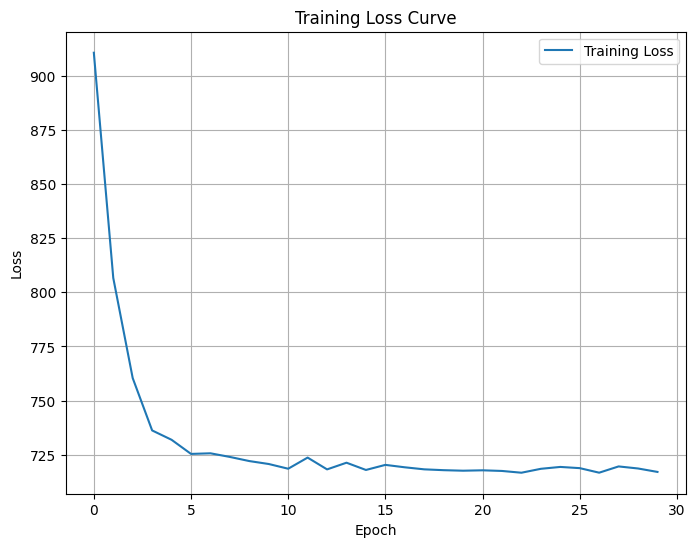

In [67]:
device = "cuda"
print("Using device", device)
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

total_loss = []
from tqdm import tqdm
with tqdm(range(epochs), desc="TRAIN") as pbar:
    for epoch in pbar:
        training_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = transformer(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
        total_loss.append(training_loss)
        pbar.set_postfix({"LOSS": training_loss})

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(total_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


Model Accuracy: 93 %


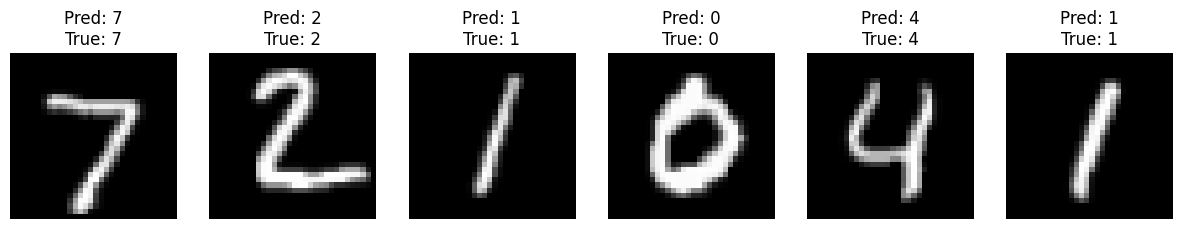

In [70]:
import numpy as np

correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = transformer(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'\nModel Accuracy: {100 * correct // total} %')
  import matplotlib.pyplot as plt

  # Get a batch of test images
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  images, labels = images.to(device), labels.to(device)

  # Predict the labels for the test images
  outputs = transformer(images)
  _, predicted = torch.max(outputs, 1)

  # Convert images to numpy for plotting
  images = images.cpu().numpy()

  # Plot the images along with the predicted and true labels
  fig, axes = plt.subplots(1, 6, figsize=(15, 5))
  for idx in range(6):
    ax = axes[idx]
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}")
    ax.axis('off')
  plt.show()